In [2]:
import numpy as np
from pathlib import Path
import plotly.graph_objects as go


from gpmdm import GPMDM
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST, RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.1 (SDL 2.30.7, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
config_path = Path.cwd() / 'models' / 'gpmdm' / 'gpmdm_config.pth'
state_path = Path.cwd() / 'models' / 'gpmdm' / 'gpmdm_state.pth'

In [4]:
reduced_columns = WALK_TRIALS_TRAIN[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [5]:
walk_train_dfs = [trial.as_dataframe() for trial in WALK_TRIALS_TRAIN]
walk_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in walk_train_dfs]

run_train_dfs = [trial.as_dataframe() for trial in RUN_TRIALS_TRAIN]
run_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in run_train_dfs]


In [ ]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [7]:
gpdm = GPMDM(
        D=DOFs,
        d=d,
        n_classes=2,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [8]:
gpdm.load(config_path, state_path)


GPDM correctly loaded


In [9]:

# Assuming gpdm.get_X_for_class is your method to get the data
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()

# Create the plot
fig = go.Figure()

# Add Class 0 data (in blue)
fig.add_trace(go.Scatter3d(
    x=X0[:, 0],
    y=X0[:, 1],
    z=X0[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Class 0'
))

# Add Class 1 data (in red)
fig.add_trace(go.Scatter3d(
    x=X1[:, 0],
    y=X1[:, 1],
    z=X1[:, 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Class 1'
))

# Update layout with axis labels and title
fig.update_layout(
    title="3D Latent Space Plot",
    scene=dict(
        xaxis_title="X-axis",
        yaxis_title="Y-axis",
        zaxis_title="Z-axis"
    )
)

# Show the interactive plot
fig.show()

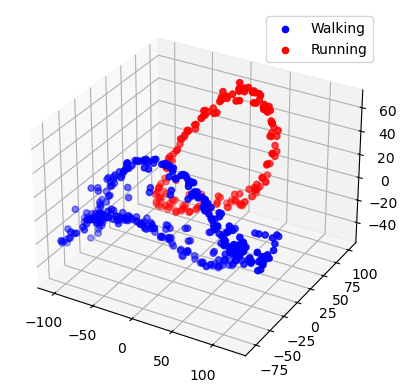

In [10]:
# Make matplotlib scatter plot

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X0[:, 0], X0[:, 1], X0[:, 2], c='b', marker='o', label='Walking')
ax.scatter(X1[:, 0], X1[:, 1], X1[:, 2], c='r', marker='o', label='Running')

ax.legend()

